## Load data and fill gaps

✅ Размер группы<br>
✅ Стартануть от базовых фич, добавляя...<br>
✅ Регрессия с L2<br>
✅ Правильный ансабль catboost (учить на части)<br>
✅ Нейронная сеть генерит фичи, а затем catboost

связь между HomePlanet и CabinDeck:<BR>
Земля на E, F, G<BR>
Марс на D, E, F<BR>
Европа на A, B, C, D, E, T

In [30]:
import os
import numpy as np 
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

df_trn = pd.read_csv("../input/spaceship-titanic/train.csv")
df_tst = pd.read_csv("../input/spaceship-titanic/test.csv")    
    
#-------------------------------------------------------------------------------------------
        
def plot_float(df):
    plt.figure(figsize=(20,8), facecolor ='w')       
    cnt = 1
    for col in df: 
        if df[col].dtype == np.float64:            
            x = df[col]
            plt.subplot(2, 6, cnt); plt.hist(x, bins=30)                            
            plt.title(f"{col} [{x.min():.0f}, {x.max():.0f}]")
            cnt += 1
    plt.show()

#-------------------------------------------------------------------------------------------
    
def plot_counts(lst_features, lst_split = ['Transported'], df = df_trn):
    cols, i = len(lst_features)*len(lst_split), 1
    plt.figure(figsize=(cols*5, 4), facecolor ='w')     
    for f in lst_features: 
        for split in lst_split:         
            plt.subplot(1, cols, i)
            sns.countplot(x=f, hue=split, data=df).set(title=f)
            i += 1
    plt.show()    

#-------------------------------------------------------------------------------------------
    
def plot_bars(lst_features, lst_split = ['Transported'], ylim=(0,1), df = df_trn):
    cols, i = len(lst_features)*len(lst_split), 1
    plt.figure(figsize=(cols*5, 4), facecolor ='w')     
    for f in lst_features: 
        for split in lst_split:         
            x = np.array( list(dict(df[f].value_counts()).items() ))            
            ax1 = plt.subplot(1, cols, i)
            plt.ylim(0, len(df)); plt.title(f); plt.yticks([])
            plt.bar(x[:,0], x[:,1].astype(int))
            
            s = [  df.loc[df[f] == k, split].mean() for k, _ in x ]
            ax2 = ax1.twinx(); ax2.set_ylim(ylim)
            plt.plot(x[:,0], s, ":og", markersize=8)
            plt.axhline(y = (ylim[0]+ylim[1])/2, color = 'gray', linestyle = '-')
            plt.yticks(np.linspace(ylim[0],ylim[1],11)); plt.legend([split])
            i += 1
    plt.show()    

#-------------------------------------------------------------------------------------------
    
def fill_gaps(df):
    """ Fill in gaps in data """
    df['GAPS'] = df.isnull().any("columns")                          # there were gaps in the row
    print(f'GAPS: {df.GAPS.mean():.3f}')
    
    for col in df:
        if df[col].dtype == float:  
            if col == "Age":
                df.loc[df[col].isnull(), col] = df[col].median()     # самый типичный возраст
            else:
                df.loc[df[col].isnull(), col] = 0                    # не знаем - не тратил :)
                
    # Spent money:        
    df['SPENT']       = df.RoomService + df.FoodCourt + df.ShoppingMall + df.Spa + df.VRDeck            
    df['SPENT_0']     = df.SPENT <= 0
    
    gaps = df.CryoSleep.isnull()                                     # все записи с неизвестной гибернацией
    df.loc[gaps, 'CryoSleep'] = df.loc[gaps, 'SPENT_0']              # не тратил - видимо спал
    df.CryoSleep = df.CryoSleep.astype(bool)
       
    gaps = df.VIP.isnull()
    df.loc[gaps, 'VIP'] = df.loc[gaps, 'SPENT'] >= 10000             # немного надумано, но VIP-пов мало,     
    df.VIP = df.VIP.astype(bool)
     
    # Частично восстанавливаем кабину по семейным парам (у них одинаковый номер)
    df["Pass_ID"]   = df.PassengerId.apply(lambda x: x.split("_")[0])
    df["Pass_NUM"]  = df.PassengerId.apply(lambda x: x.split("_")[1])
    
    indx = df[df.Cabin.isnull()].index
    for i in indx:
        ID = df.iloc[i].Pass_ID
        for k in range(1, 6):
            if i-k >=0 and df.iloc[i-k].Pass_ID == ID:
                df.iloc[i, df.columns.get_loc('Cabin')] = df.iloc[i-k].Cabin
                break            
            elif i+k < len(df) and df.iloc[i+k].Pass_ID == ID:
                df.iloc[i, df.columns.get_loc('Cabin')] = df.iloc[i+k].Cabin            
                break    
    
    # Заменяем оставшиеся NaN на "?"
    for col in df:
        if df[col].dtype == object:  
            df.loc[df[col].isnull(), col] = "?"         
            
            #df.loc[df[col].isnull(), col] = df[col].mode()[0]        # for categorical - most frequent value  - not good idea            
            #if col not in ["GAPS","Transported"]:   df[col] = df[col].astype(str)                  
    return df                

#-------------------------------------------------------------------------------------------

print(f"df_trn.shape:{df_trn.shape}  df_tst.shape:{df_tst.shape}")
display(df_trn.head(2))
display(df_trn.info())
    
df_trn = fill_gaps(df_trn)          # заполняем пропуски
df_tst = fill_gaps(df_tst)
display(df_trn.info())

df_trn.shape:(8693, 14)  df_tst.shape:(4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


None

GAPS: 0.240
GAPS: 0.233
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   object 
 2   CryoSleep     8693 non-null   bool   
 3   Cabin         8693 non-null   object 
 4   Destination   8693 non-null   object 
 5   Age           8693 non-null   float64
 6   VIP           8693 non-null   bool   
 7   RoomService   8693 non-null   float64
 8   FoodCourt     8693 non-null   float64
 9   ShoppingMall  8693 non-null   float64
 10  Spa           8693 non-null   float64
 11  VRDeck        8693 non-null   float64
 12  Name          8693 non-null   object 
 13  Transported   8693 non-null   bool   
 14  GAPS          8693 non-null   bool   
 15  SPENT         8693 non-null   float64
 16  SPENT_0       8693 non-null   bool   
 17  Pass_ID       8693 non-null   object 
 18  Pass

None

In [31]:
display(df_trn.head(2))
display(df_trn.describe(include=[object, bool]))
display(df_trn.describe())

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GAPS,SPENT,SPENT_0,Pass_ID,Pass_NUM
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,False,0.0,True,0001,01
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,False,736.0,False,0002,01


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,Transported,GAPS,SPENT_0,Pass_ID,Pass_NUM
count,8693,8693,8693,8693,8693,8693,8693,8693,8693,8693,8693,8693
unique,8693,4,2,6561,4,2,8474,2,2,2,6217,8
top,0001_01,Earth,False,?,TRAPPIST-1e,False,?,True,False,False,4498,01
freq,1,4602,5558,99,5915,8487,200,4378,6606,5040,8,6217


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,SPENT
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,28.790291,220.009318,448.434027,169.572300,304.588865,298.261820,1440.866329
std,14.341404,660.519050,1595.790627,598.007164,1125.562559,1134.126417,2803.045694
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,716.000000
75%,37.000000,41.000000,61.000000,22.000000,53.000000,40.000000,1441.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,35987.000000


✅  4378/8693 = **50.4%** - `Transported`:  **классы сбалансированы** <br>
✅  2087/8693 = **24%** **пропусков** (обычно в строке по одной фиче); в `Transported` их нет<br>
✅  6561 кают `Cabin` на 8693 человек (**1.3** человека на каюту)<br>
✅  Сильная дисперсия в финансах (от 0 до 30k)<br>
✅  Из номера пассажира следует его семейная группа (первая цифра) и номер в группе - вторая. Хотя поселиться могли в разных каютах. Иногда группа имеет разные фамилии, но одну каюту ("G/734/S")

In [ ]:
#plot_counts(['CryoSleep',  'HomePlanet',  'Destination', 'VIP' ])
plot_bars(['CryoSleep',  'HomePlanet', 'Destination', 'VIP'])
#(['Transported',  'HomePlanet', 'Destination', 'VIP'],["Age"], ylim=(0,80))
plot_float(df_trn)

## Feature engineering

In [32]:
def prepare_data(df):    
    if 'Transported' in df:
        df.Transported = df.Transported.astype(int)
        
        
    # Age:    
    df['Age_KIND'] = 0    
    df.loc[(df.Age > 4)  & (df.Age <= 12), 'Age_KIND']  = 0.1
    df.loc[(df.Age > 12) & (df.Age <= 20), 'Age_KIND']  = 0.2
    df.loc[(df.Age > 20) & (df.Age <= 30), 'Age_KIND']  = 0.3
    df.loc[(df.Age > 30) & (df.Age <= 50), 'Age_KIND']  = 0.4
    df.loc[(df.Age > 50),                  'Age_KIND']  = 0.5
    
    df.Age = df.Age / 100.        
            
    for col in  ['RoomService', 'FoodCourt',  'ShoppingMall', 'Spa', 'VRDeck']:
        share = col+"_SHARE"
        df[share] = df[col] / df['SPENT']               # доля от общих трат
        df.loc[df[share].isnull(), share] = 0           # было деление на 0
        df[col] /= 2000                                 # ближе к 1
    df.SPENT  /= 2000
    
    df['SPENT_FShSpD'] = df.FoodCourt + df.ShoppingMall + df.Spa + df.VRDeck
    df['SPENT_FSpD']   = df.FoodCourt +  df.Spa + df.VRDeck

    # Accommodation on a spaceship:
    df['Deck']       = df.Cabin.apply(lambda x: x[0]   if x != "?" else "?")
    df['Cabin_E']    = df.Cabin.apply(lambda x: x[-1]  if x != "?" else "?" )                 # S or P
    df['Number']     = df.Cabin.apply(lambda x: float(x[2:-2]) / 1000 if x != "?" else -1 )   # max 1894  
    df['Number_E']   = df.Cabin.apply(lambda x: int(x[2:-2]) % 2 if x != "?" else -1 )   # max 1894      

    df['Deck_BCD']   = df.Deck.apply(lambda x: x in 'BCD' )    
    df['Deck_BCDFA'] = df.Deck.apply(lambda x: x in 'BCDFA' )        
    df['Deck_DET']   = df.Deck.apply(lambda x: x in 'DET' )    
    
    df['CryoSleep_Deck_BCDFA'] = (df.CryoSleep  == True)  & (df.Deck_BCDFA)     
    df['~CryoSleep_Deck_DET']  = (df.CryoSleep  == False) & (df.Deck_DET) 
            
    # Passenger's name:
    df['FN']         = df.Name.apply(lambda x: x.split(' ')[0])
    df['SN']         = df.Name.apply(lambda x: x.split(' ')[-1])
    df['FN_END']     = df.FN.apply(lambda x: x[-1:])    
    df['FN_END_T']   = df.FN.apply(lambda x: 1 if x[-1] in "skhxmbrozif" else ( 0 if x[-1] in "yple" else 0.5) )
    
    return df

df_trn = prepare_data(df_trn)
df_tst = prepare_data(df_tst)

#display(df_trn.Cabin_S.value_counts());   print()
#display(df_trn.Deck.value_counts());      print()
#display(df_trn.FN_END.value_counts())

display(df_trn.describe(include=[object]))
display(df_trn.describe(include=[bool]))
display(df_trn.describe())

,PassengerId,HomePlanet,Cabin,Destination,Name,Pass_ID,Pass_NUM,Deck,Cabin_E,FN,SN,FN_END
count,8693,8693,8693,8693,8693,8693,8693,8693,8693,8693,8693,8693
unique,8693,4,6561,4,8474,6217,8,9,3,2707,2218,23
top,0001_01,Earth,?,TRAPPIST-1e,?,4498,01,F,S,?,?,y
freq,1,4602,99,5915,200,8,6217,2808,4343,200,200,1383


,CryoSleep,VIP,GAPS,SPENT_0,Deck_BCD,Deck_BCDFA,Deck_DET,CryoSleep_Deck_BCDFA,~CryoSleep_Deck_DET
count,8693,8693,8693,8693,8693,8693,8693,8693,8693
unique,2,2,2,2,2,2,2,2,2
top,False,False,False,False,False,True,False,False,False
freq,5558,8487,6606,5040,6649,5114,7315,7185,7605


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,SPENT,Age_KIND,RoomService_SHARE,FoodCourt_SHARE,ShoppingMall_SHARE,Spa_SHARE,VRDeck_SHARE,SPENT_FShSpD,SPENT_FSpD,Number,Number_E,FN_END_T
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,0.287903,0.110005,0.224217,0.084786,0.152294,0.149131,0.503624,0.720433,0.305073,0.128203,0.127274,0.107228,0.110746,0.106326,0.610429,0.525642,0.580380,0.487174,0.486081
std,0.143414,0.330260,0.797895,0.299004,0.562781,0.567063,0.500016,1.401523,0.121269,0.279254,0.272017,0.254100,0.252848,0.248907,1.362487,1.330894,0.536306,0.522153,0.401736
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000
25%,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.158000,0.000000,0.000000
50%,0.270000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.358000,0.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.118000,0.005000,0.414000,0.000000,0.500000
75%,0.370000,0.020500,0.030500,0.011000,0.026500,0.020000,1.000000,0.720500,0.400000,0.030479,0.044630,0.016260,0.032712,0.023632,0.481500,0.393000,0.990000,1.000000,1.000000
max,0.790000,7.163500,14.906500,11.746000,11.204000,12.066500,1.000000,17.993500,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,17.931000,17.931000,1.894000,1.000000,1.000000


In [33]:
%%time
def amounts_mean(df, lst = ["SPENT", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]):   
    """
    Одна группа могла записывать траты деньги на одного члена (например, главу), но ходить все, кто не в капсуле
    """
    for ls in lst:
        df[ls + "_MEAN"] = 0

    ids = dict(df.Pass_ID.value_counts())
    for ID, NUM in ids.items():            
        if NUM == 1:
            break            
        for ls in lst:            
            dd = df.loc[(df.Pass_ID == ID) & (df.CryoSleep == False), ls]
            df.loc[dd.index, ls+'_MEAN'] = dd.mean()                                        
    return df

df_trn = amounts_mean(df_trn)
df_tst = amounts_mean(df_tst)

df_trn[['SPENT_MEAN', "RoomService_MEAN", "FoodCourt_MEAN", "ShoppingMall_MEAN", "Spa_MEAN", "VRDeck_MEAN"]].describe()

CPU times: user 23.5 s, sys: 1.84 ms, total: 23.5 s
Wall time: 23.5 s


,SPENT_MEAN,RoomService_MEAN,FoodCourt_MEAN,ShoppingMall_MEAN,Spa_MEAN,VRDeck_MEAN
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,0.365869,0.046025,0.126736,0.033596,0.080325,0.079187
std,1.025468,0.197555,0.529048,0.171520,0.341766,0.350332
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,14.804000,7.163500,9.240500,5.873000,6.951000,8.653000


## Some experiments with features

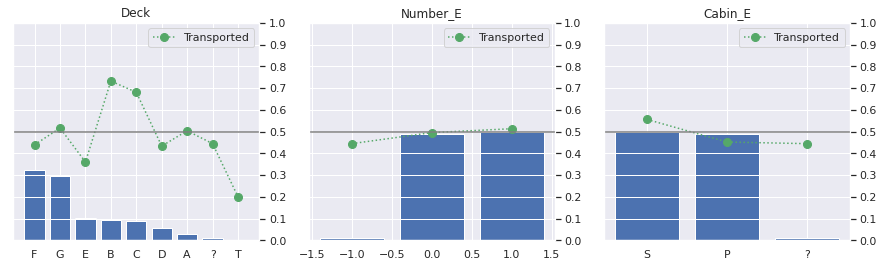

Number of people in the cabin (trn):
Cabin   bodies   transp
?           99    0.444 
F/1194/P     8    0.125 
G/734/S      8    0.375 
G/1368/P     7    0.429 
C/21/P       7    0.714 
G/981/S      7    1.000 
G/657/P      7    0.571 


,PassengerId,Cabin,CryoSleep,Name,Transported
4221,4498_01,G/734/S,False,Valex Munozanson,0
4222,4498_02,G/734/S,True,Loise Beckeetter,0
4223,4498_03,G/734/S,True,Lorie Beckeetter,1
4224,4498_04,G/734/S,False,Dandy Munozanson,0
4225,4498_05,G/734/S,True,Karay Beckeetter,1
4226,4498_06,G/734/S,False,Line Munozanson,1
4227,4498_07,G/734/S,False,Dary Mallerez,0
4228,4498_08,G/734/S,False,Kendy Munozanson,0


,PassengerId,Cabin,CryoSleep,Name,Transported
3574,3850_01,C/137/S,False,Keidhma Unteckery,0
3575,3850_02,C/137/S,True,Astula Unteckery,1
3576,3850_03,C/137/S,False,Achib Unteckery,1
3577,3850_04,C/137/S,True,Alchium Unteckery,1
3578,3850_05,C/137/S,True,Thallah Unteckery,1
3579,3850_06,C/137/S,False,Sabiark Unteckery,1
3580,3850_07,C/137/S,True,Azharga Chuble,1



Same cabins in trn and tst: 0


In [34]:
plot_bars(['Deck', 'Number_E', 'Cabin_E'])

print("Number of people in the cabin (trn):")
print("Cabin   bodies   transp")
for cabin, v in  dict(df_trn.Cabin.value_counts()[:7]).items():
    print(f"{cabin:10s} {v:3d}    {df_trn.loc[df_trn.Cabin==cabin,  'Transported'].mean():.3f} ")
    
tot = 0
for k,v in  dict(df_trn.Cabin.value_counts()).items():
    if k != '?':
        tot += len(df_tst.loc[df_tst.Cabin == k])
        
display(df_trn.loc[df_trn.Cabin == "G/734/S", ["PassengerId", "Cabin","CryoSleep", "Name", "Transported"]])
display(df_trn.loc[df_trn.Cabin == "C/137/S", ["PassengerId", "Cabin","CryoSleep", "Name", "Transported"]])
         
    
print(f"\nSame cabins in trn and tst: {tot}")        

✅ Кабины в trn и tst не пересекаются, т.е. выборка tst не вполне случайна <br>
✅ Палубам `B` и `C` досталось больше всего<br>
✅ Есть кабины с большим числом пассажиров <br>

In [36]:
x = df_trn.loc[(df_trn.SPENT_0), 'Transported']
print(f"SPENT_0                  > count:{x.count():4d},   mean:{x.mean():.3f}")

x = df_trn.loc[(df_trn.CryoSleep), 'Transported']
print(f"CryoSleep==T             > count:{x.count():4d},   mean:{x.mean():.3f}")

x = df_trn.loc[(df_trn.CryoSleep == False), 'Transported']
print(f"CryoSleep==F             > count:{x.count():4d},   mean:{x.mean():.3f}")

x = df_trn.loc[(df_trn.CryoSleep) & (df_trn.Deck_BCD), 'Transported']
print(f"\nCryoSleep==T, Deck_BCD   > count:{x.count():4d},   mean:{x.mean():.3f}")

x = df_trn.loc[(df_trn.CryoSleep) & (df_trn.Deck_BCDFA), 'Transported']
print(f"CryoSleep==T, Deck_BCDFA > count:{x.count():4d},   mean:{x.mean():.3f}")

x = df_trn.loc[(df_trn.CryoSleep  == False) & (df_trn.Deck_DET), 'Transported']
print(f"CryoSleep==F, Deck_DET   > count:{x.count():4d},   mean:{x.mean():.3f}\n")

for d in 'BCDFAGET?':
    number = df_trn.loc[df_trn.Deck == d].Number
    x = df_trn.loc[(df_trn.CryoSleep ) & (df_trn.Deck == d) , 'Transported']  #  &  (df_trn.Number < 500)
    print(f"CryoSleep==T, Deck_{d}     > count:{x.count():4d},   mean:{x.mean():.3f},    {number.max():.3f}")    

SPENT_0                  > count:3653,   mean:0.786
CryoSleep==T             > count:3135,   mean:0.815
CryoSleep==F             > count:5558,   mean:0.328

CryoSleep==T, Deck_BCD   > count: 858,   mean:0.993
CryoSleep==T, Deck_BCDFA > count:1508,   mean:0.984
CryoSleep==F, Deck_DET   > count:1088,   mean:0.281

CryoSleep==T, Deck_B     > count: 438,   mean:0.993,    0.353
CryoSleep==T, Deck_C     > count: 312,   mean:0.994,    0.342
CryoSleep==T, Deck_D     > count: 108,   mean:0.991,    0.295
CryoSleep==T, Deck_F     > count: 575,   mean:0.977,    1.894
CryoSleep==T, Deck_A     > count:  75,   mean:0.933,    0.107
CryoSleep==T, Deck_G     > count:1407,   mean:0.656,    1.508
CryoSleep==T, Deck_E     > count: 182,   mean:0.648,    0.608
CryoSleep==T, Deck_T     > count:   0,   mean:nan,    0.003
CryoSleep==T, Deck_?     > count:  38,   mean:0.763,    -1.000


✅  
Те кто не тратил деньги, в большинстве лежали в капсулах, поэтому многие из них пропали.<br>
✅  Капсулы `CryoSleep` стоят в каютах. Видимо, корабль пересёк анамалию и больше досталось конкретным палубам, номерам и возможно общественным местам.<br>
✅  Впрочем, капсула минимум 0.65 гарантии пропажи вне зависимости от положения.<br> 
✅  Любым методом acc = **0.72** только с `CryoSleep` (3 значения ?,F,T)

In [37]:
res = dict(df_trn.FN_END.value_counts())
tot, st = 0, ""
for i, k in enumerate(res):
    x = df_trn.loc[(df_trn.FN_END == k) , 'Transported']  
    count, mean = x.count(), x.mean()
    if mean > 0.55 and count > 10:
        print(f"{k:12s}:{res[k]:3d} > count:{count:4d}, mean:{mean:.3f}")                
        st += k
        tot += count
        
print(tot, st)  

s           :998 > count: 998, mean:0.557
k           :453 > count: 453, mean:0.572
h           :373 > count: 373, mean:0.603
x           :205 > count: 205, mean:0.556
m           :153 > count: 153, mean:0.627
b           :130 > count: 130, mean:0.715
r           :129 > count: 129, mean:0.628
o           :103 > count: 103, mean:0.563
z           : 65 > count:  65, mean:0.585
i           : 54 > count:  54, mean:0.611
f           : 25 > count:  25, mean:0.560
2688 skhxmbrozif


✅  Последняя буква имени возможно связана с полом человека:  `skhxmbrozif` (mean > 0.55);   `yple` (mean < 0.45; 2930)<br>

In [ ]:
for i in range(1, 80, 3):    
    x = df_trn.loc[(df_trn.Age  > (i-1)/100 ) & (df_trn.Age  <= (i)/100), 'Transported'] 
    print(f"[{i-1:4.0f} - {i:4.0f}]  count:{x.count():4d},   mean:{x.mean():.3f}")    

## Some Plots

In [ ]:
   
plot_hist(['CryoSleep', 'SPENT_0', 'HomePlanet', 'Destination'])    

In [ ]:
plot_hist([ 'Deck_BCD', 'Deck_BCDFA', 'Deck'])    

Землян больше выжило, потому что их селили на удачные палубы и они меньше зказывали криокапсул

In [ ]:
plot_hist([ 'CryoSleep_Deck_BCDFA', '~CryoSleep_Deck_TEG'])    

In [ ]:
plot_hist(['Deck', 'Destination', 'SPENT_0', 'CryoSleep'], 'HomePlanet')    

In [ ]:
df = pd.DataFrame({'mean':df_trn.groupby('Deck')['Transported'].mean(), 
                   'sum': df_trn.groupby('Deck')['Transported'].sum()})
display(df)
#display(df.loc[df['mean'] > 0.5])  # BC, AG, DEFT

# Test and Train 

In [38]:
# Средние значения bool признаков для тестовых и тренировочных данных:
for col in df_tst:                          
    if df_tst[col].dtype == bool:        
        m_tst, m_trn =   df_tst[col].mean(), df_trn[col].mean(),
        print(f"{m_tst:.2f}   {m_trn:.2f}  {m_tst-m_trn:5.2f}  {col}")

0.37   0.36   0.01  CryoSleep
0.02   0.02  -0.00  VIP
0.23   0.24  -0.01  GAPS
0.42   0.42   0.00  SPENT_0
0.23   0.24  -0.01  Deck_BCD
0.59   0.59   0.00  Deck_BCDFA
0.16   0.16   0.00  Deck_DET
0.18   0.17   0.01  CryoSleep_Deck_BCDFA
0.13   0.13   0.00  ~CryoSleep_Deck_DET


✅  Тестовая выборка выглядит такой же как тренировочной, **НО** каюты не пересекаются, так что...

# Encoding of categorical features 

In [39]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

CAT = {
    'HomePlanet' : { 'vals': ['?', 'Mars', 'Europa', 'Earth' ] },
    'Destination': { 'vals': ['?', "PSO J318.5-22", "55 Cancri e", "TRAPPIST-1e"] },
    'Deck'       : { 'vals': ['?', 'F', 'G', 'E', 'B', 'C', 'D', 'A', 'T'] },
    'Cabin_E'    : { 'vals': ['?', 'S',    'P'] },
}

def encode(df_trn, df_tst, CAT, HOT1 = True, HOT2 = True):          # onehot or label
    for feature, v in CAT.items():
        vals = v['vals']
        onehot = (len(vals) <= 4 and HOT1) or (len(vals) > 4 and HOT2)
        
        if onehot:
            enc = OneHotEncoder(categories = [vals], handle_unknown='ignore')
            columns = [feature + "_" + category for category in vals]
            v['cols'] = columns 
            df_trn = df_trn.join( pd.DataFrame( enc.fit_transform( df_trn[[feature]] ).toarray(), columns = columns ) )
            df_tst = df_tst.join( pd.DataFrame( enc.fit_transform( df_tst[[feature]] ).toarray(), columns = columns ) )            
        else:
            enc = OrdinalEncoder(categories = [vals])            
            v['cols'] = [feature+"_ord"]
            df_trn = df_trn.join( pd.DataFrame( enc.fit_transform( df_trn[[feature]]), columns = [feature+"_ord"] ) )
            df_tst = df_tst.join( pd.DataFrame( enc.fit_transform( df_tst[[feature]]), columns = [feature+"_ord"] ) )
            
    return df_trn, df_tst   

df_trn, df_tst = encode(df_trn, df_tst, CAT,  HOT1 = True, HOT2 = True)

#display(df_trn.head())

## Train data

In [ ]:
df_trn = pd.read_csv("../input/spaceship-titanic/train.csv")
df_tst = pd.read_csv("../input/spaceship-titanic/test.csv")

df_trn = fill_gaps(df_trn)
df_tst = fill_gaps(df_tst)

df_trn = prepare_data(df_trn)
df_tst = prepare_data(df_tst)

df_trn = amounts_mean(df_trn)
df_tst = amounts_mean(df_tst)

df_trn, df_tst = encode(df_trn, df_tst, CAT,  HOT1 = True, HOT2 = True)

In [9]:
print(", ".join(["'"+s+"'" for s in list(df_trn.columns)]))

'PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported', 'GAPS', 'SPENT', 'SPENT_0', 'Pass_ID', 'Pass_NUM', 'Age_KIND', 'RoomService_SHARE', 'FoodCourt_SHARE', 'ShoppingMall_SHARE', 'Spa_SHARE', 'VRDeck_SHARE', 'SPENT_FShSpD', 'SPENT_FSpD', 'Deck', 'Cabin_E', 'Number', 'Number_E', 'Deck_BCD', 'Deck_BCDFA', 'Deck_DET', 'CryoSleep_Deck_BCDFA', '~CryoSleep_Deck_DET', 'FN', 'SN', 'FN_END', 'FN_END_T', 'SPENT_MEAN', 'RoomService_MEAN', 'FoodCourt_MEAN', 'ShoppingMall_MEAN', 'Spa_MEAN', 'VRDeck_MEAN', 'HomePlanet_?', 'HomePlanet_Mars', 'HomePlanet_Europa', 'HomePlanet_Earth', 'Destination_?', 'Destination_PSO J318.5-22', 'Destination_55 Cancri e', 'Destination_TRAPPIST-1e', 'Deck_F', 'Deck_G', 'Deck_E', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_A', 'Deck_T', 'Deck_?', 'Cabin_E_?', 'Cabin_E_S', 'Cabin_E_P'


In [53]:
def FE(feature):
    return CAT[feature]['cols']

# base:
FEATURE_KIND = 'all'

if   FEATURE_KIND == 'base':
    COLUMNS = ['Age',  "RoomService","FoodCourt","ShoppingMall", "Spa", "VRDeck", 'Number'
              ] + FE('CryoSleep') + FE('VIP') + FE('Cabin_E')+ FE('HomePlanet') + FE('Destination') + FE('Deck')
        
elif   FEATURE_KIND == 'small':        
    COLUMNS =  FE('CryoSleep') + ['CryoSleep_Deck_BCDFA', '~CryoSleep_Deck_DET']
    
elif FEATURE_KIND == 'all':
    # catboost(4, 0.1, 300): 0.815:
    COLUMNS = [          
     'CryoSleep', 'VIP', # 'GAPS'
     'Age',  'Age_KIND',
     'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
     'SPENT', 'SPENT_0', 'RoomService_SHARE', 'FoodCourt_SHARE', 'ShoppingMall_SHARE', 'Spa_SHARE', 'VRDeck_SHARE', 'SPENT_FShSpD', 'SPENT_FSpD',
     'SPENT_MEAN', "RoomService_MEAN", "FoodCourt_MEAN", "ShoppingMall_MEAN", "Spa_MEAN", "VRDeck_MEAN",
     'Number', 'Number_E', 'Deck_BCD', 'Deck_BCDFA',  'CryoSleep_Deck_BCDFA', '~CryoSleep_Deck_DET',
     'FN_END_T',
    ] +  FE('Cabin_E')+ FE('HomePlanet') + FE('Destination') + FE('Deck')
elif FEATURE_KIND == 'all_best':
    # catboost(4, 0.1, 300): 0.816, 0.818:
    #COLUMNS = ['SPENT', 'Number', 'FoodCourt_SHARE', 'CryoSleep_Deck_BCDFA', 'Age', 'SPENT_MEAN', 'Deck_BCD', 'ShoppingMall_SHARE', 'Cabin_E_S', 'Deck_BCDFA', 'Cabin_E_P', 'CryoSleep', 'VRDeck', 'SPENT_0', 'Spa', 'Spa_SHARE', 'Spa_MEAN', 'VRDeck_SHARE', 'Deck_E', 'SPENT_FSpD', 'SPENT_FShSpD', 'RoomService_SHARE', 'Deck_C', 'HomePlanet_Mars', 'ShoppingMall', 'HomePlanet_Earth', 'RoomService', 'Destination_TRAPPIST-1e', 'Deck_F', 'FoodCourt', 'HomePlanet_Europa', 'FoodCourt_MEAN', ]
    COLUMNS = ['Number', 'SPENT_FShSpD', 'SPENT', 'FoodCourt_SHARE', 'CryoSleep_Deck_BCDFA', 'Age', 'VRDeck_SHARE', 'Spa_SHARE', 'CryoSleep', 'RoomService_SHARE', 'Spa', 'HomePlanet_Earth', 'Cabin_E_P', 'SPENT_FSpD', 'VRDeck', 'Cabin_E_S', 'RoomService', 'HomePlanet_Mars', 'ShoppingMall_SHARE', 'HomePlanet_Europa', 'FoodCourt', 'Deck_BCD', 'Deck_E', 'ShoppingMall', 'Deck_C', 'Deck_G', 'FoodCourt_MEAN', 'Destination_TRAPPIST-1e', 'Spa_MEAN', 'FN_END_T', ]
    
    # catboost(4, 0.1, 300): 0.819, 0.817 (remove impot==0)    
    #COLUMNS = ['Number', 'SPENT', 'FoodCourt_SHARE', 'CryoSleep_Deck_BCDFA', 'Age', 'SPENT_FShSpD', 'CryoSleep_True', 'ShoppingMall_SHARE', 'Spa', 'Spa_SHARE', 'VRDeck', 'Cabin_E_P', 'VRDeck_SHARE', 'HomePlanet_Mars', 'FoodCourt', 'SPENT_FSpD', 'RoomService_SHARE', 'ShoppingMall', 'Deck_BCD', 'RoomService', 'Deck_E', 'Deck_BCDFA', 'HomePlanet_Europa', 'Cabin_E_S', 'HomePlanet_Earth', 'Deck_C', 'Destination_TRAPPIST-1e', 'Deck_G', ]
    
    #COLUMNS = ['Number', 'SPENT_0', 'SPENT', 'FoodCourt_SHARE', 'CryoSleep_Deck_BCDFA', 'Age', 'SPENT_MEAN', 'Deck_BCDFA', 'ShoppingMall_SHARE', 'Cabin_E_P', 'Spa_SHARE', 'HomePlanet_Europa', 'VRDeck_SHARE', 'Spa_MEAN', 'HomePlanet_Mars', 'Deck_C', 'SPENT_FSpD', 'VRDeck_MEAN', 'Cabin_E_S', 'Deck_G', 'SPENT_FShSpD', 'Spa', 'RoomService_MEAN', 'ShoppingMall_MEAN', 'Deck_E', 'Deck_BCD', 'RoomService_SHARE', 'FoodCourt_MEAN', 'ShoppingMall', 'CryoSleep_False', 'CryoSleep_True', 'VRDeck', 'Destination_TRAPPIST-1e', 'FoodCourt', ]    
    #COLUMNS =['SPENT_MEAN', 'Number', 'SPENT', 'Deck_BCDFA', 'FoodCourt_SHARE', 'Age', 'CryoSleep_True', 'ShoppingMall_SHARE', 'CryoSleep_Deck_BCDFA', 'HomePlanet_Mars', 'SPENT_FShSpD', 'Cabin_E_S', 'Spa_SHARE', 'Cabin_E_P', 'Spa_MEAN', 'RoomService_MEAN', ]
    
elif FEATURE_KIND == 'hand':    
    COLUMNS = ['CryoSleep',  'Age', 'VIP', "RoomService","FoodCourt","ShoppingMall", "Spa", "VRDeck", 'SPENT', 'SPENT_0',  'Cabin_S', 'Number', 'CryoSleep_Deck_BCDFA', '~CryoSleep_Deck_TEG', 'Deck_FA', 'Deck_BCDFA', 'Deck_TEG',]   + DECKS      
    
elif FEATURE_KIND == 'tst':
    #COLUMNS = ['Number', 'SPENT', 'FoodCourt_SHARE', 'Cabin_S', 'Age', 'ShoppingMall_SHARE', 'Spa_SHARE', 'SPENT_FSpD', 'Deck_BCDFA', 'SPENT_FShSpD', 'ShoppingMall', 'FoodCourt', 'VRDeck', 'TRAPPIST-1e', 'C', 'CryoSleep', 'Spa', 'Europa', 'VRDeck_SHARE', 'RoomService', 'Earth', 'RoomService_SHARE', 'E', 'Deck_BCD', 'Deck_FA', 'Mars', 'A', '55 Cancri e', 'G']

    # catboost(4, 0.1, 300): 0.817:
    COLUMNS = ['SPENT', 'Number', 'FoodCourt_SHARE', 'CryoSleep_Deck_BCDFA', 'SPENT_FShSpD', 'Planet', 'Age', 'Cabin_S', 'ShoppingMall_SHARE', 'Spa', 'ShoppingMall', 'Spa_SHARE', 'VRDeck', 'VRDeck_SHARE', 'FoodCourt', 'Deck_BCDFA', 'C', 'E', 'RoomService', 'RoomService_SHARE', 'SPENT_FSpD', 'Dest', 'CryoSleep', 'Deck_BCD', ]
    
    #COLUMNS = ['Number', 'VRDeck', 'FoodCourt', 'SPENT', 'Spa', 'ShoppingMall', 'Cabin_S', 'RoomService', 'Age', 'E', 'Earth', 'TRAPPIST-1e', 'C', 'G', 'CryoSleep', ]
else:
    COLUMNS = []
    
X = df_trn[COLUMNS]
Y = df_trn.Transported

#X = df_trn.loc[df_trn.CryoSleep,  COLUMNS]
#Y = df_trn.loc[df_trn.CryoSleep,  'Transported']

X = X.to_numpy().astype(np.float32) 
Y = Y.to_numpy().astype(np.int64) 

print(X.shape)
display(df_trn[COLUMNS].head(3))
#display(df_trn[COLUMNS].info())

(8693, 51)


,CryoSleep,VIP,Age,Age_KIND,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,SPENT,...,Destination_TRAPPIST-1e,Deck_?,Deck_F,Deck_G,Deck_E,Deck_B,Deck_C,Deck_D,Deck_A,Deck_T
0,False,False,0.39,0.4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,False,False,0.24,0.3,0.0545,0.0045,0.0125,0.2745,0.0220,0.3680,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,False,True,0.58,0.5,0.0215,1.7880,0.0000,3.3575,0.0245,5.1915,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Models

## Simple models

Чтобы модели не переобучались: 
- в`DecisionTree` надо уменьшать `max_depth`
- в `KNeighborsClassifier`  увеличивать `n_neighbors`

In [46]:
import time
from sklearn.model_selection import cross_val_score
from sklearn.linear_model    import LogisticRegression, RidgeClassifier
from sklearn.svm             import LinearSVC 
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.naive_bayes     import GaussianNB
from sklearn.tree            import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

CROSS_VAL_IT = 5
CROSS_VAL_CV = 20

def shuffle_data(X,Y):
    idx = np.random.permutation(len(Y)) 
    return X[idx], Y[idx]        
    
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),     # smaller C - specify stronger regularization.
    #'LinearSVC'          : LinearSVC(max_iter=1000, ),
    #'RidgeClassifier'   : RidgeClassifier(),
    'KNeighbors'        : KNeighborsClassifier(),
    #'GaussianNB'        : GaussianNB(),
    'DecisionTree'      : DecisionTreeClassifier(),    
}

def eval_simple(X,Y):
    for name, clf in models.items():    
        res = np.array([])
        tm1 = time.process_time() 
        for _ in range(CROSS_VAL_IT):
            X, Y = shuffle_data(X,Y)
            r = cross_val_score(clf, X, Y, cv=CROSS_VAL_CV)
            res = np.concatenate([res, r])
        tm2 = time.process_time()
        print(f"{res.mean():.3f} ± {res.std()/len(res)**0.5:.3f}  {(tm2-tm1)/(CROSS_VAL_CV*CROSS_VAL_IT):.2f}s  {name}")    

eval_simple(X,Y)    

0.796 ± 0.002  0.55s  LogisticRegression
0.783 ± 0.002  0.57s  KNeighbors
0.758 ± 0.002  0.10s  DecisionTree


In [ ]:
clf = LogisticRegression(max_iter=1000, random_state=0)
res = cross_val_score(clf, X, Y, cv=5)
print(f"{res.mean():.3f} ± {res.std():.3f}", res)

clf.fit(X,Y)
X_tst = df_tst[COLUMNS].to_numpy()  
Y_tst = clf.predict(X_tst)
print(f"{clf.score(X,Y):.3f}", Y_tst.shape, Y_tst)

##  DecisionTree
* samples:100, depth:5 > 0.793 ± 0.002

In [47]:
class CFG:        
    min_samples_leaf = 100
    max_depth        = 5

def eval_DecisionTreeClassifier(X,Y):    
    res = np.array([])
    tm1 = time.process_time() 
    for r_state in range(CROSS_VAL_IT):
        X, Y = shuffle_data(X,Y)    
        clf = DecisionTreeClassifier(max_depth=CFG.max_depth, min_samples_leaf=CFG.min_samples_leaf,  random_state=r_state)
        r = cross_val_score(clf, X, Y, cv=CROSS_VAL_CV)        
        res = np.concatenate([res, r])
    tm2 = time.process_time()
    print(f"{res.mean():.3f} ± {res.std()/len(res)**0.5:.3f}  {(tm2-tm1)/(CROSS_VAL_CV*CROSS_VAL_IT):.2f}s  DecisionTree")     

eval_DecisionTreeClassifier(X,Y)

0.788 ± 0.002  0.04s  DecisionTree


In [ ]:
par, mean, std = [], [],[]
for sample in [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300]:
    clf = DecisionTreeClassifier(max_depth=CFG.max_depth, min_samples_leaf=sample)
    r = cross_val_score(clf, X, Y, cv=10)
    par.append(sample), mean.append(r.mean()); std.append(r.std())
    print(f"{sample:3d}:  {r.mean():.3f} ± {r.std():.3f}")

plt.errorbar(par, mean, yerr=std, fmt='-o');

In [63]:
%%time
from sklearn.model_selection import GridSearchCV
params = {'max_depth'        : [3, 4, 5, 6, 7, 8],
          'min_samples_leaf' : [30,40,45,50,55,60,80,90],          
        }

grid = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid = params, cv = 10, n_jobs=-1)
res = grid.fit(X, Y)

print(res.best_score_)
print(res.best_params_)

0.7938628096768647
{'max_depth': 5, 'min_samples_leaf': 55}
CPU times: user 778 ms, sys: 30.3 ms, total: 808 ms
Wall time: 9.57 s


## Bag Ensemble

In [ ]:
from sklearn.ensemble import BaggingClassifier

X, Y = shuffle_data(X,Y)
X_trn,  X_val, Y_trn, Y_val = train_test_split(X, Y, test_size=0.2)

bag = BaggingClassifier(LogisticRegression(max_iter=1000),  max_samples=0.5, max_features=0.8)
bag.fit(X_trn, Y_trn)
print(f"{bag.score(X_val,Y_val):.3f}")
print(f"{bag.score(X_trn,Y_trn):.3f}")
print(f"{bag.score(X,Y):.3f}")

## SVM

In [ ]:
from sklearn.svm import SVC, NuSVC

tm1 = time.process_time() 
clf = SVC()
res = cross_val_score(clf, X, Y, cv=CROSS_VAL_CV)
tm2 = time.process_time()
print(f"{res.mean():.3f} ± {res.std()/len(res)**0.5:.3f}  {(tm2-tm1)/CROSS_VAL_CV:.2f}s  SVC")    

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

class CFG:    
    n_estimators     = 100
    min_samples_leaf =  10
    max_depth        =  20    

res, ITS = np.array([]), 5
tm1 = time.process_time() 
for r_state in range(ITS):
    X, Y = shuffle_data(X,Y)    
    clf = RandomForestClassifier(n_estimators=CFG.n_estimators, max_depth=CFG.max_depth, min_samples_leaf=CFG.min_samples_leaf, random_state=r_state)
    r = cross_val_score(clf, X, Y, cv=CROSS_VAL_CV)        
    print(f"\r{r_state:2d}: {r.mean():.3f} ± {r.std()/len(r)**0.5:.3f}", end="")        
    res = np.concatenate([res, r])
tm2 = time.process_time()
print(f"\n{res.mean():.3f} ± {res.std()/len(res)**0.5:.3f}  {(tm2-tm1)/(CROSS_VAL_CV*ITS):.2f}s  RandomForest")         

## GradientBoostingClassifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

class CFG:    
    n_estimators = 300
    max_depth    = 30

tm1 = time.process_time() 
clf = GradientBoostingClassifier(n_estimators=CFG.n_estimators, max_depth=CFG.max_depth, random_state=0)
res = cross_val_score(clf, X, Y, cv=CROSS_VAL_CV)
tm2 = time.process_time()
print(f"{res.mean():.3f} ± {res.std()/len(res)**0.5:.3f}  {(tm2-tm1)/CROSS_VAL_CV:.2f}s  RandomForest")    

## CatBoost

In [49]:
import catboost
from catboost import CatBoostClassifier

class CFG: 
    """ https://docs.aws.amazon.com/sagemaker/latest/dg/catboost-tuning.html """
    method          = 'catboost'                           # recommend:
    max_depth       = 4       # Valid:int[1,16], Def:6     Grid:[4,10]        > Depth of the tree
    l2_leaf_reg     = None    # Valid:int>0,     Def:3     Grid:[2,10]        > Coefficient for the L2 regularization term of the cost function.
    random_strength = 3       # Valid:float>0    Def:1     Grid:[0,10]        > The amount of randomness to use for scoring splits when the tree structure is selected. Use this parameter to avoid overfitting the model.
    learning_rate   = 0.1     # Valid:float[0,1] Def:0.009 Grid:[0.001, 0.01] > The rate at which the model weights are updated after working through each batch of training examples (0,1) 
    iterations      = 300     #                  Def:500   Grid:[]            > The maximum number of trees that can be built 
    ensemble        = 13

def eval_CatBoostClassifier(X,Y):    
    res = np.array([])
    tm1 = time.process_time() 
    for r_state in range(CROSS_VAL_IT):
        X, Y = shuffle_data(X,Y)
    
        #clf = CatBoostClassifier( verbose=0,  random_state=r)
        clf = CatBoostClassifier(iterations=CFG.iterations, learning_rate=CFG.learning_rate, l2_leaf_reg=CFG.l2_leaf_reg, random_strength=CFG.random_strength, verbose=0,  random_state=r_state)        

        r = cross_val_score(clf, X, Y, cv=CROSS_VAL_CV, n_jobs=-1)
        res = np.concatenate([res, r])
        
        print(f"\r{r_state+1:2d}: {r.mean():.3f} ± {r.std()/len(r)**0.5:.3f} ", end="")        
        
    tm2 = time.process_time()
    print(f"\n{res.mean():.3f} ± {res.std()/len(res)**0.5:.3f}  {(tm2-tm1)/(CROSS_VAL_CV*CROSS_VAL_IT):.2f}s  CatBoostClassifier")     
      
eval_CatBoostClassifier(X,Y)    

 5: 0.815 ± 0.004 
0.815 ± 0.002  0.00s  CatBoostClassifier


  0:  0.811 ± 0.012
  1:  0.813 ± 0.016
  2:  0.815 ± 0.012
  3:  0.817 ± 0.010
  4:  0.817 ± 0.014
  5:  0.817 ± 0.011
  6:  0.816 ± 0.015
  7:  0.812 ± 0.009
  8:  0.813 ± 0.016
  9:  0.815 ± 0.012
 10:  0.812 ± 0.008


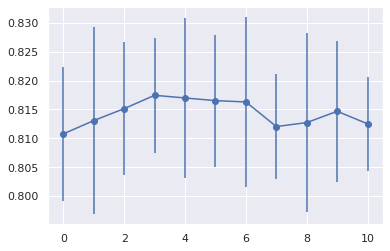

In [97]:
print(CFG)
pars, mean, std = [], [],[]
for par in [0,1,2,3,4,5,6,7,8,9,10]:
    X, Y = shuffle_data(X,Y)
    #clf = CatBoostClassifier(iterations=CFG.iterations, learning_rate=CFG.learning_rate, l2_leaf_reg=CFG.l2_leaf_reg, random_strength=par, verbose=0,  random_state=0)    
    clf = CatBoostClassifier(iterations=CFG.iterations, learning_rate=CFG.learning_rate, l2_leaf_reg=CFG.l2_leaf_reg, random_strength=CFG.random_strength, verbose=0,  random_state=0)            
    r = cross_val_score(clf, X, Y, cv=CROSS_VAL_CV, n_jobs=-1)
    pars.append(par), mean.append(r.mean()); std.append(r.std())
    print(f"{par:3d}:  {r.mean():.3f} ± {r.std():.3f}")
    
plt.errorbar(pars, mean, yerr=std, fmt='-o');

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV
params = {'depth'         : [3, 4, 5, 6],  
          'l2_leaf_reg'   : [1,5,10,30,50,70,100],            # try different values for the regularizer to find the best possible. Any positive values are allowed.
          'iterations'    : [100,200,300,400]                 # the maximum number of trees that can be built
          'learning_rate' : [0.01,0.05,0.1,0.15,0.2],         # the smaller the value, the more iterations are required for training.
        }

grid = GridSearchCV(estimator=CatBoostClassifier(), param_grid = params, cv = 10, n_jobs=-1)
res = grid.fit(X, Y, verbose=0)

print(res.best_score_)
print(res.best_params_)

In [ ]:
%%time
grid = {'learning_rate': [0.03, 0.1],
        'depth':         [4, 6, 10],
         'l2_leaf_reg':  [1, 3, 5,]}

ds_trn = catboost.Pool(X,Y)
clf = CatBoostClassifier(iterations=1000, loss_function='Logloss', eval_metric='Accuracy', verbose=0)

clf.grid_search(grid, ds_trn, plot=True)

In [ ]:
clf.get_all_params()

In [ ]:
clf = CatBoostClassifier(iterations=CFG.iterations, learning_rate=CFG.learning_rate, verbose=0,  random_state=0)
clf.fit(X,Y)
X_tst = df_tst[COLUMNS].to_numpy()  
Y_tst = clf.predict(X_tst)
print(f"{clf.score(X,Y):.3f}", Y_tst.shape, Y_tst)

### Selecting the important features

In [43]:
clf = CatBoostClassifier(iterations=CFG.iterations, learning_rate=CFG.learning_rate, l2_leaf_reg=CFG.l2_leaf_reg, random_strength=CFG.random_strength, verbose=0,  random_state=0)        
clf.fit(X,Y)        
imps = clf.feature_importances_
imps = [(COLUMNS[i], im) for i, im in enumerate(imps)]
imps = sorted(imps, key = lambda x: -x[1])
st = ""
for im in imps:
    print(f"{im[1]:4.0f}   {im[0]}")
    if im[1] >= 1:
        st += f"'{im[0]}', "
print("["+st+"]")

  10   Number
   6   SPENT_FShSpD
   6   SPENT
   5   FoodCourt_SHARE
   5   CryoSleep_Deck_BCDFA
   4   Age
   4   VRDeck_SHARE
   4   Spa_SHARE
   4   CryoSleep
   3   RoomService_SHARE
   3   Spa
   3   HomePlanet_Earth
   3   Cabin_E_P
   3   SPENT_FSpD
   2   VRDeck
   2   Cabin_E_S
   2   RoomService
   2   HomePlanet_Mars
   2   ShoppingMall_SHARE
   2   HomePlanet_Europa
   2   FoodCourt
   2   Deck_BCD
   2   Deck_E
   2   ShoppingMall
   1   Deck_C
   1   Deck_G
   1   FoodCourt_MEAN
   1   Destination_TRAPPIST-1e
   1   Spa_MEAN
   1   FN_END_T
   1   ShoppingMall_MEAN
   1   Deck_F
   1   Age_KIND
   1   ~CryoSleep_Deck_DET
   1   Deck_BCDFA
   1   SPENT_MEAN
   1   VRDeck_MEAN
   1   RoomService_MEAN
   0   Destination_55 Cancri e
   0   Deck_A
   0   Number_E
   0   Deck_B
   0   Destination_PSO J318.5-22
   0   HomePlanet_?
   0   Destination_?
   0   VIP
   0   Deck_D
   0   Cabin_E_?
   0   Deck_T
   0   SPENT_0
   0   Deck_?
['Number', 'SPENT_FShSpD', 'SPENT', 'FoodCo

In [ ]:
#print(COLUMNS[26])
clf.plot_tree(tree_idx=0)

### Ensamble

In [ ]:
from sklearn.ensemble import BaggingClassifier

X, Y = shuffle_data(X,Y)
X_trn,  X_val, Y_trn, Y_val = train_test_split(X, Y, test_size=0.2)

bag = BaggingClassifier(
    CatBoostClassifier(iterations=CFG.iterations, learning_rate=CFG.learning_rate, verbose=0,  random_state=0),
    max_samples=0.9, max_features=0.8)
bag.fit(X_trn, Y_trn)
print(f"{bag.score(X_val,Y_val):.3f}")
print(f"{bag.score(X_trn,Y_trn):.3f}")
print(f"{bag.score(X,Y):.3f}")

In [ ]:
res = cross_val_score(
    BaggingClassifier(
        CatBoostClassifier(iterations=CFG.iterations, learning_rate=CFG.learning_rate, verbose=0,  random_state=0),
        max_samples=0.9, max_features=0.8),     
    X, Y, cv=CROSS_VAL_CV)
print(f"{res.mean():.3f} ± {res.std()/len(res)**0.5:.3f}")    

In [89]:
X_tst = df_tst[COLUMNS].to_numpy()  
probs, scores = None, []                               # ансамбль моделей
for r in range(CFG.ensemble):    
    idx = np.random.permutation(len(Y)) 
    X, Y = X[idx], Y[idx]    
        
    clf = CatBoostClassifier(iterations=CFG.iterations, learning_rate=CFG.learning_rate, verbose=0,  random_state=r)
    clf.fit(X[100:],Y[100:])                          # чуть разные данные
        
    #Y_r   = clf.predict(X_tst).reshape(-1,1)   
    p = clf.predict_proba(X_tst)[:,1:]
    probs = p if probs is None else np.concatenate([probs, p], axis = 1 )
    score = clf.score(X,Y)
    print(f"\r{r:2d} {score:.3f} {probs.shape}", end="")
    scores.append(score)
print(f"\n{np.mean(scores):.3f} ± {np.std(scores):.3f}")
Y_tst =  probs.mean(axis=1) > 0.5

12 0.890 (4277, 13)
0.893 ± 0.001


In [101]:
Y_tst =  probs.mean(axis=1) > 0.45

## LightGBM

In [60]:
import lightgbm as lgb

class CFG:
    method          = 'lgb'          #
    tree_type       = 'dart'         # Def:'gbdt'   Val:('dart' 'gbdt' 'goss')
    
    n_estimators    = 200            # Def:100
    learning_rate   = 0.1            # Def:0.1
    
        
    # Это очень важный параметр для предотвращения чрезмерной подгонки в листовом дереве.
    # Его оптимальное значение зависит от количества обучающих выборок и num_leaves
    #min_data_in_leaf = 100
    
    max_depth     = -1
    
    ensemble      = 13

res = np.array([])
tm1 = time.process_time() 
for r_state in range(CROSS_VAL_IT):
    X, Y = shuffle_data(X,Y)
    
    clf = lgb.LGBMClassifier(boosting_type=CFG.tree_type,  learning_rate=CFG.learning_rate, num_leaves=65,  random_state=r_state)
    r = cross_val_score(clf, X, Y, cv=CROSS_VAL_CV)
    res = np.concatenate([res, r])
    print(f"\r{r_state:2d}  {r.mean():.3f} ± {r.std()/len(r)**0.5:.3f}  LGBMClassifier", end="")        
    
tm2 = time.process_time()
print(f"\n{res.mean():.3f} ± {res.std()/len(res)**0.5:.3f}  {(tm2-tm1)/(CROSS_VAL_CV*CROSS_VAL_IT):.2f}s  LGBMClassifier")            

 9  0.808 ± 0.004  LGBMClassifier
0.810 ± 0.001  2.80s  LGBMClassifier


In [ ]:
clf.fit(X,Y, verbose=0,  eval_metric='logloss')  # , eval_set=[(X_val,Y_val),(X_trn,Y_trn)]
lgb.plot_importance(clf)
#lgb.plot_metric(clf)
#lgb.plot_tree(clf, figsize=(30,40), show_info=['data_percentage'])
print(COLUMNS[9], COLUMNS[7], COLUMNS[4], COLUMNS[6])

### Ensamble

In [ ]:
Y_tst = None                               # ансамбль моделей
for r in range(CFG.ensemble):    
    idx = np.random.permutation(len(Y)) 
    X, Y = X[idx], Y[idx]    
        
    clf = lgb.LGBMClassifier(boosting_type=CFG.tree_type, learning_rate=CFG.learning_rate, max_depth=CFG.max_depth,  random_state=r)
    clf.fit(X,Y, eval_set=[(X_val,Y_val),(X_trn,Y_trn)], verbose=0,  eval_metric='logloss')        
    
    X_tst = df_tst[COLUMNS].to_numpy()  
    Y_r   = clf.predict(X_tst).reshape(-1,1)        
    Y_tst = Y_r if Y_tst is None else np.concatenate([Y_tst, Y_r], axis = 1 )
    print(f"{clf.score(X,Y):.3f} {Y_tst.shape}")

    Y_tst = (Y_tst.mean(axis=1) > 0.5)    

# Feature Seclection

 Одномерный отбор признаков

In [ ]:
from sklearn.feature_selection import SelectPercentile 
select = SelectPercentile(percentile=80) 
select.fit(X, Y) 
X_sel = select.transform(X) 
print(f"{X.shape} -> {X_sel.shape}")
mask = select.get_support() 
plt.matshow(mask.reshape(1, -1), cmap='gray_r'); plt.show()

#eval_simple(X_sel,Y)    
eval_CatBoostClassifier(X_sel, Y) 

Класс `SelectFromModel` отбирает все признаки, у которых показатель 
важности  (заданный ML моделью ) превышает  установленное  пороговое  значение.  
Мы  использовали  в  качестве  порогового  значения  медиану,  поэтому  будет  отобрана  половина  признаков.  

In [ ]:
from sklearn.feature_selection import SelectFromModel 
select = SelectFromModel( 
    CatBoostClassifier(iterations=CFG.iterations, learning_rate=CFG.learning_rate, verbose=0,  random_state=0),
    threshold="0.05*mean")  # "median"
 
select.fit(X, Y) 
X_sel = select.transform(X) 
print(f"{X.shape} -> {X_sel.shape}")
mask = select.get_support() 
plt.matshow(mask.reshape(1, -1), cmap='gray_r'); plt.show()

#eval_simple(X_sel,Y) 
eval_CatBoostClassifier(X_sel, Y)   

Метод рекурсивного исключения признаков начинается  с  включения  всех  признаков,  строит  модель  и 
исключает  наименее  важный  признак  с  точки  зрения  модели.  Затем 
строится  новая  модель  с  использованием  всех  признаков,  кроме 
исключенного, и так далее, пока не останется лишь заранее определенное 
количество признаков.

In [ ]:
from sklearn.feature_selection import RFE 
select = RFE(CatBoostClassifier(iterations=CFG.iterations, learning_rate=CFG.learning_rate, verbose=0,  random_state=0),
             n_features_to_select=35) 
 
select.fit(X, Y) 
X_sel = select.transform(X) 
print(f"{X.shape} -> {X_sel.shape}")
mask = select.get_support() 
plt.matshow(mask.reshape(1, -1), cmap='gray_r'); plt.show()

#eval_simple(X_sel,Y) 
eval_CatBoostClassifier(X_sel, Y)   

In [ ]:
%%time
from sklearn.feature_selection import SequentialFeatureSelector

select = SequentialFeatureSelector(
    CatBoostClassifier(iterations=CFG.iterations, learning_rate=CFG.learning_rate, verbose=0,  random_state=0),
    n_features_to_select = None, direction="backward", cv=5)

select.fit(X, Y) 
X_sel = select.transform(X) 
print(f"{X.shape} -> {X_sel.shape}")
mask = select.get_support() 
plt.matshow(mask.reshape(1, -1), cmap='gray_r'); plt.show()

#eval_simple(X_sel,Y) 
eval_CatBoostClassifier(X_sel, Y)   

cols = [ "'"+COLUMNS[i]+"'" for i, s in enumerate(mask) if s]
print("[" + ", ".join(cols) + "]")

# NNet

torch.Size([51])
torch.Size([6954, 51]) torch.Size([6954, 1]) torch.float32 torch.float32
epoch:  5000 loss: 0.3337 (0.403) accuracy: 0.8424 (0.802)

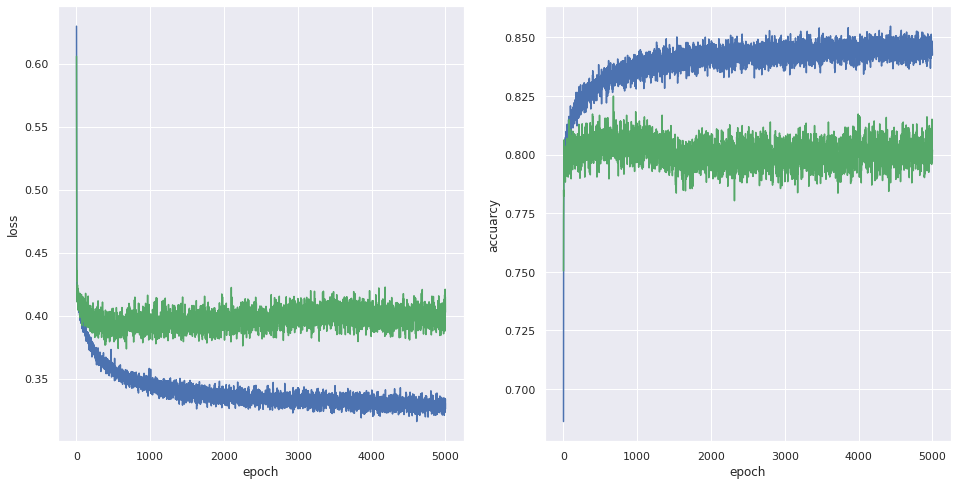

In [61]:
import torch
import torch.nn as nn

nX, nH, nY = X.shape[-1], 32, 1
 
model = nn.Sequential(
          nn.BatchNorm1d(nX),
          nn.Dropout(0.1),
          nn.Linear(nX, nH),  
          nn.Dropout(0.1),
          nn.ReLU(),      
          nn.Linear(nH, nH),  
          nn.Dropout(0.1),
          nn.ReLU(),          
          nn.Linear(nH, nY),     
          nn.Sigmoid() )     

print(model[0].weight.shape)

loss      = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,  weight_decay=1e-4)   # 

def fit(model, X,Y, batch_size=512, train=True):    
    batch_size = min(batch_size, len(X))
    totLoss, totAcc, totBatches = 0, 0, 0                # losses and  accuracies
                   
    idx = torch.randperm( len(X) )                       # permuted index list
    X, Y = X[idx], Y[idx]        
    
    model.train(train)                                   # important for Dropout, BatchNorm layers    
    for i in range(0, len(Y), batch_size):             
        nb = min(batch_size,  len(Y)-i)
        
        xb, yb = X[i: i+nb], Y[i: i+nb]                  # current batch        
                      
        y = model(xb)                                    # forward propagation
        L = loss(y, yb)                                  # calculate the loss
  
        if train:                                        # we are in learning mode
            optimizer.zero_grad()                        # reset the gradients        
            L.backward()                                 # calculate gradients            
            optimizer.step()                             # adjusting parameters
                               
        totLoss    += L.detach()
        totAcc     += (y.detach().round() == yb).float().mean()
        totBatches += 1
          
    return totLoss/totBatches, totAcc/totBatches         # mean error and accuracy

X_data, Y_data = torch.tensor(X.astype(np.float32)), torch.tensor(Y.astype(np.float32)).view(-1,1)
X_trn,  X_val, Y_trn, Y_val = train_test_split(X_data, Y_data, test_size=0.2)
print(X_trn.shape, Y_trn.shape, X_trn.dtype, Y_trn.dtype)

epochs = 5000                                             # number of epochs

history = [] 
for epoch in range(1,epochs+1):                          
    L_trn,A_trn = fit(model, X_trn, Y_trn)                               # one epoch
    L_val,A_val = fit(model, X_val, Y_val, train=False)                  
    history.append((epoch, L_trn, A_trn, L_val, A_val))
     
    if epoch % 10 == 0 or epoch == epochs:                 
        print(f'\repoch: {epoch:5d} loss: {L_trn:.4f} ({L_val:.3f}) accuracy: {A_trn:.4f} ({A_val:.3f})', end="" ) 
    
history = np.array(history)                              # learning output
plt.figure(figsize=(16,8))              
plt.subplot(1, 2, 1); plt.xlabel('epoch'); plt.ylabel('loss')
plt.plot(history[1:,0], history[1:, 1], "-b")
plt.plot(history[1:,0], history[1:, 3], "-g")
  
plt.subplot(1, 2, 2);  plt.xlabel('epoch'); plt.ylabel('accuarcy')
plt.plot(history[1:,0], history[1:, 2], "-b")
plt.plot(history[1:,0], history[1:, 4], "-g")
plt.show()

# Names

In [ ]:
!pip install -q gender_guesser

import gender_guesser.detector as gender
gd = gender.Detector()
print(gd.get_gender(u"Bob"), "\n")

df_trn['Sex'] = df_trn.FN.apply(lambda x: gd.get_gender(x) )

print(df_trn.Sex.describe(), "\n")
print(df_trn.Sex.value_counts())

# Save Submition

In [102]:
print(Y_tst.shape)
submission = pd.DataFrame()
submission["PassengerId"] =  df_tst.PassengerId
submission["Transported"] =  Y_tst.astype(bool)

submission.to_csv("submission.csv", index=False)

print(f"mean:{Y_tst.mean():.3f}")
display(submission.head())
display(submission.Transported.value_counts())

(4277,)
mean:0.541


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


True     2314
False    1963
Name: Transported, dtype: int64